# Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Problem Defintion
The goal of this task is to build a machine learning solution to predict the credit score category of customers based on their financial, personal, and behavioral attributes.Financial institutions can use these predictions to assess customer creditworthiness, enabling more informed lending decisions.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CreditScorePrediction/train.csv')


<ipython-input-28-fc902d441cf7>:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CreditScorePrediction/train.csv')


In [ ]:
df.head(5)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


# Data Cleaning

In [ ]:
# Shape Of The Dataset
df.shape

(100000, 28)

In [ ]:
# let’s see if there are null valuecs
df.isna().sum()

,0
ID,0
Customer_ID,0
Month,0
Name,9985
Age,0
SSN,0
Occupation,0
Annual_Income,0
Monthly_Inhand_Salary,15002
Num_Bank_Accounts,0


- Name: 9,985 missing (not likely useful for analysis; can be dropped).
- Monthly_Inhand_Salary: 15,002 missing.
- Type_of_Loan: 11,408 missing.
- Num_of_Delayed_Payment: 7,002 missing.
- Credit_History_Age: 9,030 missing.
- Amount_invested_monthly: 4,479 missing.
- Monthly_Balance: 1,200 missing.

In [ ]:
# some info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

- Many columns are listed as object but should be numeric (Age, Annual_Income, Num_of_Loan, etc.).

- Credit_History_Age contains textual data and needs to be converted to numerical format.

- Columns like Credit_Mix and Payment_Behaviour are categorical and require encoding.

In [ ]:
# let’s see if there are duplicated values
df.duplicated().sum()

0

- Looks good, no duplicate values.

 ## Handle Missing Values
- Numerical columns:
   - Impute Monthly_Inhand_Salary, Amount_invested_monthly, and Monthly_Balance with their median values to maintain                  consistency and robustness.  
   
   - Annual_Income, Num_of_Loan,Num_of_Delayed_Payment,Num_Credit_Inquiries, Outstanding_Debt : Impute using a K-Nearest   Neighbors (KNN) Imputer,This method will impute the missing values based on the relationships with other columns in the dataset, providing a more context-sensitive estimate.

- Categorical columns:
     - For Type_of_Loan, use a placeholder value ("Unknown") to retain rows.
     
     - Credit_History_Age: Convert textual data to numerical format, then impute missing values with the median.




In [ ]:
# Function to clean and impute numeric columns
def clean_and_impute_numeric_column(df, column_name):
    """
    Cleans and imputes missing values in a numeric column of a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the column.
        column_name (str): The name of the column to clean and impute.

    Returns:
        pd.DataFrame: The updated DataFrame with cleaned and imputed column.
    """
    # Convert column to numeric, replacing invalid values with NaN
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')

    # Impute missing values with the median
    median_value = df[column_name].median()
    df[column_name].fillna(median_value, inplace=True)

    print(f"Column '{column_name}' cleaned and missing values imputed with median: {median_value}")
    return df


# List of columns to clean and impute
columns_to_impute = ['Monthly_Inhand_Salary', 'Amount_invested_monthly', 'Monthly_Balance']

# Apply the cleaning and imputation function to each column
for column in columns_to_impute:
    df = clean_and_impute_numeric_column(df, column)




Column 'Monthly_Inhand_Salary' cleaned and missing values imputed with median: 3093.745000000001
Column 'Amount_invested_monthly' cleaned and missing values imputed with median: 128.95453805190283
Column 'Monthly_Balance' cleaned and missing values imputed with median: 336.73122455696387


<ipython-input-34-0f379befec19>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(median_value, inplace=True)


In [ ]:
# Function to convert 'Credit_History_Age' from 'XX Years and YY Months' format to total months
def convert_credit_history(age):
    if pd.isnull(age):
        return np.nan
    years, months = map(int, re.findall(r'\d+', age))
    return years * 12 + months

# Impute missing categorical values
df['Type_of_Loan'].fillna('Unknown', inplace=True)

# Convert 'Credit_History_Age' to numerical format (in months)
df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_credit_history)

# Impute missing values for 'Credit_History_Age' with median
df['Credit_History_Age'].fillna(df['Credit_History_Age'].median(), inplace=True)


<ipython-input-35-2ff3b0ffb083>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Type_of_Loan'].fillna('Unknown', inplace=True)
<ipython-input-35-2ff3b0ffb083>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [ ]:
df['Credit_History_Age']

,Credit_History_Age
0,265.0
1,219.0
2,267.0
3,268.0
4,269.0
...,...
99995,378.0
99996,379.0
99997,380.0
99998,381.0


#### Convert Data Types
  - Columns like Age, Annual_Income, Num_of_Loan, Num_of_Delayed_Payment, and Outstanding_Debt should be converted to numeric types.

In [ ]:
# List of columns to convert to numeric types
numeric_columns = ['Age', 'Annual_Income', 'Num_of_Loan',
                   'Num_of_Delayed_Payment', 'Outstanding_Debt']

# Convert each specified column to numeric, coercing errors to NaN
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Verify the data types of the columns
print(df.dtypes)


ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                         float64
SSN                          object
Occupation                   object
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                 float64
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment      float64
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age          float64
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Payment_Behaviour            object
Monthly_Balance             float64
Credit_Score                

In [ ]:
# Function for KNN imputation
def impute_with_knn(df, columns, n_neighbors=5):
    """
    Applies K-Nearest Neighbors (KNN) imputation to the specified columns in the DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the columns to impute.
        columns (list): A list of column names to apply KNN imputation.
        n_neighbors (int): The number of neighbors to use for imputation.

    Returns:
        pd.DataFrame: The updated DataFrame with missing values imputed.
    """
    # Initialize the KNN imputer with the specified number of neighbors
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Apply KNN imputer to the specified columns and update the DataFrame
    df[columns] = imputer.fit_transform(df[columns])

    # Print a message indicating which columns were imputed
    print(f"KNN imputation applied to columns: {columns}")

    # Return the DataFrame with imputed values
    return df

columns_knn = ['Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
               'Num_Credit_Inquiries', 'Outstanding_Debt']

# Apply KNN imputation for more context-sensitive imputation
df = impute_with_knn(df, columns_knn)

KNN imputation applied to columns: ['Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Outstanding_Debt']


In [ ]:
print(df.isnull().sum())

ID                             0
Customer_ID                    0
Month                          0
Name                        9985
Age                         4939
SSN                            0
Occupation                     0
Annual_Income                  0
Monthly_Inhand_Salary          0
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Type_of_Loan                   0
Delay_from_due_date            0
Num_of_Delayed_Payment         0
Changed_Credit_Limit           0
Num_Credit_Inquiries           0
Credit_Mix                     0
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age             0
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly        0
Payment_Behaviour              0
Monthly_Balance                0
Credit_Score                   0
dtype: int64


 #### Remove Redundant Columns and Handle Categorical Data
 - Drop columns such as ID, Customer_ID, Name, and SSN as they do not provide predictive power.

 - Encode categorical columns such as Credit_Mix, Payment_Behaviour, and Payment_of_Min_Amount using Label Encoding or One-Hot Encoding.

In [ ]:
# Remove redundant columns
df.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'], inplace=True)

# Encode categorical columns using Label Encoding or One-Hot Encoding

# Columns for Label Encoding (Ordinal)
label_columns = ['Payment_of_Min_Amount']

# Apply Label Encoding
label_encoder = LabelEncoder()
for col in label_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Columns for One-Hot Encoding (Nominal)
one_hot_columns = ['Credit_Mix', 'Payment_Behaviour']

# Apply One-Hot Encoding
df_Clean = pd.get_dummies(df, columns=one_hot_columns, drop_first=True)


In [ ]:
# Verify the changes
df_Clean.head(5)

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,...,Credit_Score,Credit_Mix_Good,Credit_Mix_Standard,Credit_Mix__,Payment_Behaviour_High_spent_Large_value_payments,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments
0,January,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,False,False,True,False,False,True,False,False,False
1,February,23.0,Scientist,19114.12,3093.745000,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,True,False,False,False,False,False,True,False,False
2,March,-500.0,Scientist,19114.12,3093.745000,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,True,False,False,False,False,False,False,True,False
3,April,23.0,Scientist,19114.12,3093.745000,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,True,False,False,False,False,False,False,False,True
4,May,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,True,False,False,False,True,False,False,False,False


-  Invalid -500.0 value in the Age column!

In [ ]:
print(df_Clean.isnull().sum())

Month                                                    0
Age                                                   4939
Occupation                                               0
Annual_Income                                            0
Monthly_Inhand_Salary                                    0
Num_Bank_Accounts                                        0
Num_Credit_Card                                          0
Interest_Rate                                            0
Num_of_Loan                                              0
Type_of_Loan                                             0
Delay_from_due_date                                      0
Num_of_Delayed_Payment                                   0
Changed_Credit_Limit                                     0
Num_Credit_Inquiries                                     0
Outstanding_Debt                                         0
Credit_Utilization_Ratio                                 0
Credit_History_Age                                      

## Handle Outliers
- Check for and handle outliers in columns like Age, Annual_Income, and Credit_Utilization_Ratio using boxplots or z-scores.

- Handle the Negative Age Value: Replace or remove any rows where Age is negative.
- Handle Outliers in Age, Annual_Income, and Credit_Utilization_Ratio: Using the IQR method, cap or remove outliers in these columns.

In [ ]:
# Remove rows where Age is negative
df_Clean = df_Clean[df['Age'] >= 0]

# Handling outliers function
def handle_outliers(df, column_name):
    """
    Identifies and handles outliers in a given column using the IQR method.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the column.
        column_name (str): The name of the column to check for outliers.

    Returns:
        pd.DataFrame: The DataFrame with outliers handled.
    """
    # Calculate Q1, Q3, and IQR
    Q1 = df_Clean[column_name].quantile(0.25)
    Q3 = df_Clean[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers to the lower and upper bounds
    df_Clean[column_name] = df_Clean[column_name].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

    print(f"Outliers in '{column_name}' handled by capping with IQR method.")
    return df_Clean

# Handle outliers for columns: Age, Annual_Income, Credit_Utilization_Ratio
outlier_columns = ['Age', 'Annual_Income', 'Credit_Utilization_Ratio']
for column in outlier_columns:
    df_Clean = handle_outliers(df_Clean, column)

# Check the result
df_Clean[outlier_columns].describe()


Outliers in 'Age' handled by capping with IQR method.
Outliers in 'Annual_Income' handled by capping with IQR method.
Outliers in 'Credit_Utilization_Ratio' handled by capping with IQR method.


,Age,Annual_Income,Credit_Utilization_Ratio
count,94175.000000,94175.000000,94175.000000
mean,33.971181,51495.406809,32.288268
std,11.653174,38091.349051,5.116861
min,14.000000,7005.930000,20.000000
25%,25.000000,19920.930000,28.052581
50%,33.000000,38685.980000,32.313152
75%,42.000000,72389.880000,36.498290
max,67.500000,151093.305000,49.166853


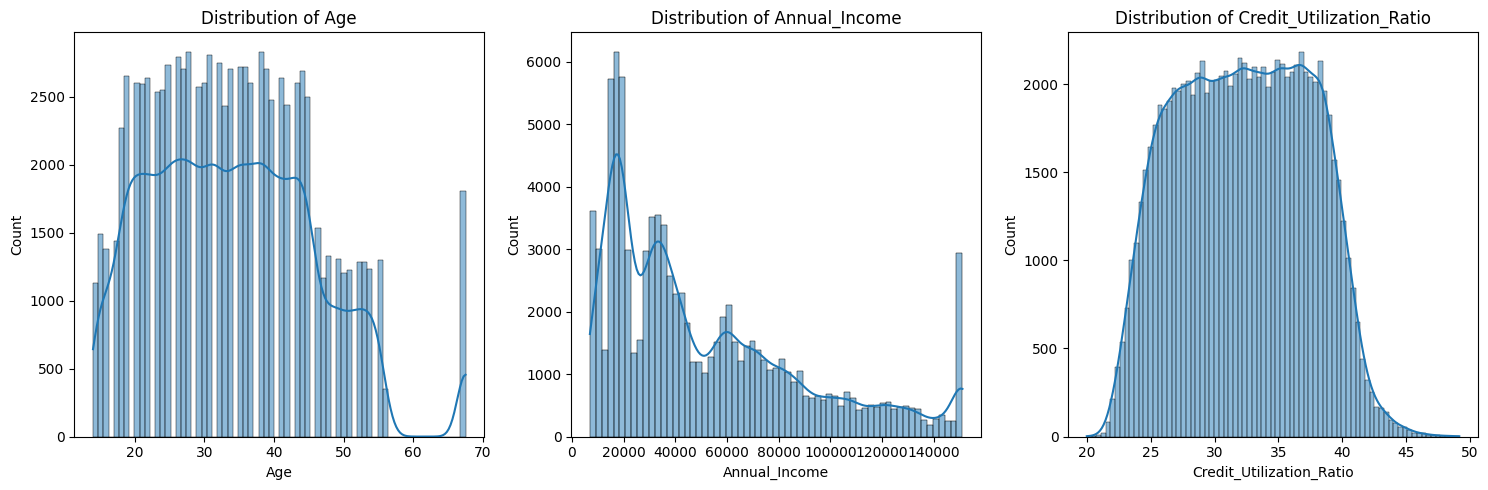

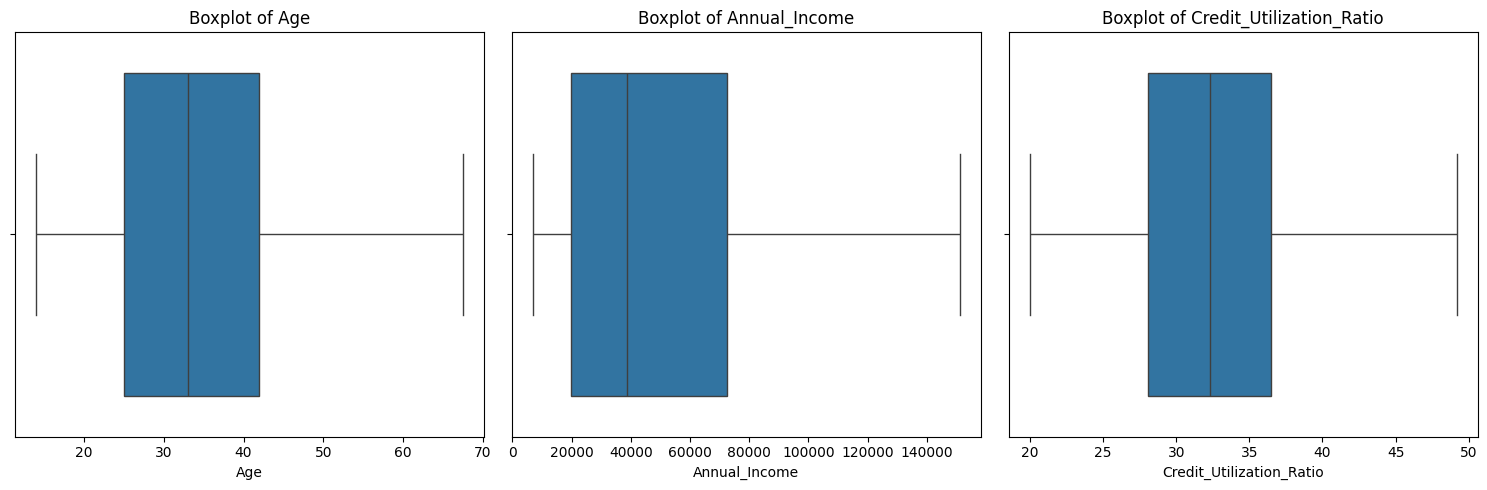

In [ ]:
# Plot histograms for all three columns
plt.figure(figsize=(15, 5))
for i, column in enumerate(outlier_columns, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df_Clean[column], kde=True)
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

# Plot boxplots to identify any remaining outliers
plt.figure(figsize=(15, 5))
for i, column in enumerate(outlier_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df_Clean[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()


# Exploratory Data Analysis (EDA)

In [ ]:
# Summary statistics for numerical columns
df_Clean.describe().T



,count,mean,std,min,25%,50%,75%,max
Age,94175.0,33.971181,11.653174,14.000000,25.000000,33.000000,42.000000,67.500000
Annual_Income,94175.0,51495.406809,38091.349051,7005.930000,19920.930000,38685.980000,72389.880000,151093.305000
Monthly_Inhand_Salary,94175.0,4030.994353,2960.031908,303.645417,1795.805417,3093.745000,5375.913333,15204.633333
Num_Bank_Accounts,94175.0,17.194170,117.782825,-1.000000,3.000000,6.000000,7.000000,1798.000000
Num_Credit_Card,94175.0,22.483239,129.110554,0.000000,4.000000,5.000000,7.000000,1499.000000
Interest_Rate,94175.0,72.293900,465.523852,1.000000,8.000000,13.000000,20.000000,5797.000000
Num_of_Loan,94175.0,2.819750,61.451843,-100.000000,1.000000,3.000000,5.000000,1496.000000
Delay_from_due_date,94175.0,21.056289,14.849839,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_of_Delayed_Payment,94175.0,31.480437,218.981494,-3.000000,9.000000,14.000000,18.000000,4397.000000
Num_Credit_Inquiries,94175.0,27.555925,191.500047,0.000000,3.000000,6.000000,9.000000,2597.000000


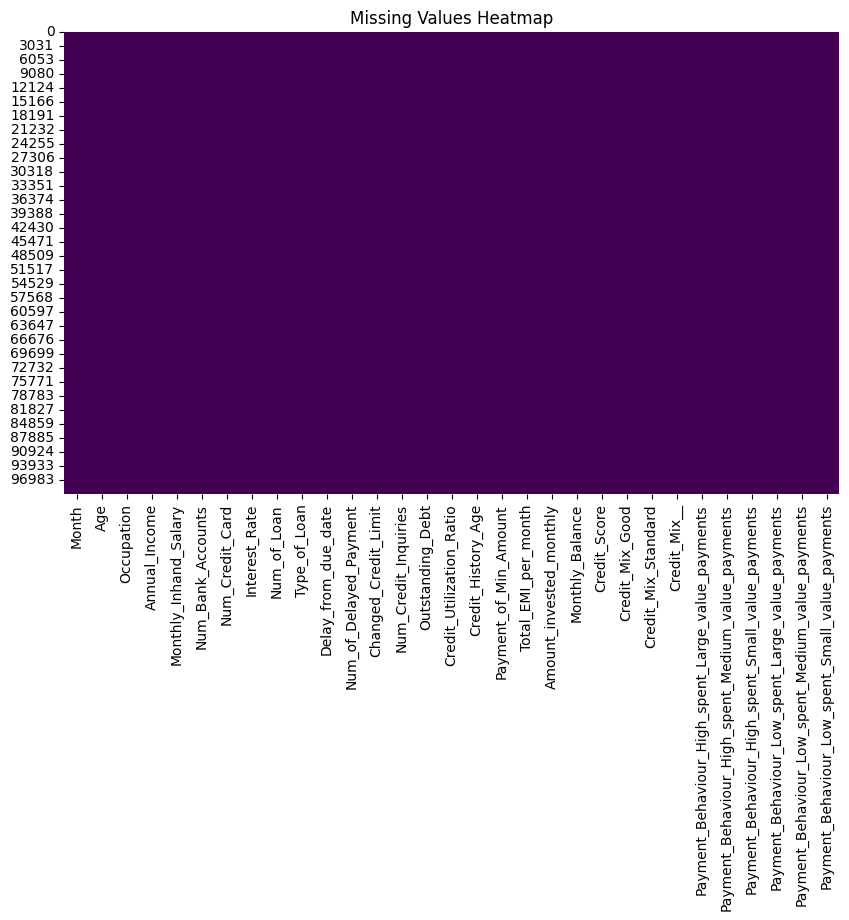

In [ ]:
# Heatmap for missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df_Clean.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

- Now the data is clean, let's plot diagrams to get insights

# Univariate Analysis

        - Numerical Features:
                                  Histograms: To check the distribution of numerical variables.
                                  
                                  Boxplots: To identify outliers.

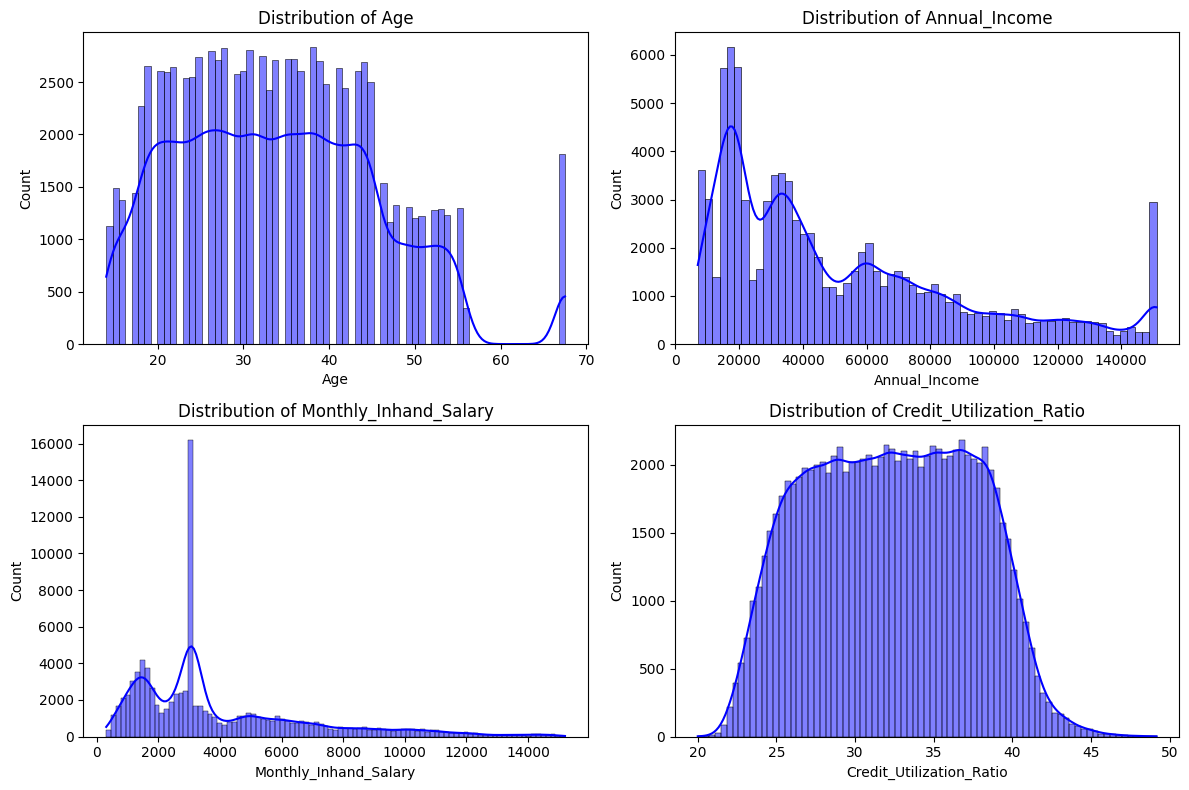

In [ ]:
# Distribution of key numerical columns
numerical_columns = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Credit_Utilization_Ratio']

plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_Clean[col], kde=True, color='blue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

- Age: Majority are in their 20s-40s, with fewer older individuals.
- Annual Income: Skewed right, with most earning under $40,000. Spikes at $140,000 suggest data anomalies.
- Monthly Salary: Significant spike around $4,000, indicating possible data issues.
- Credit Utilization: Mostly falls between 20%-50%, showing balanced credit usage.

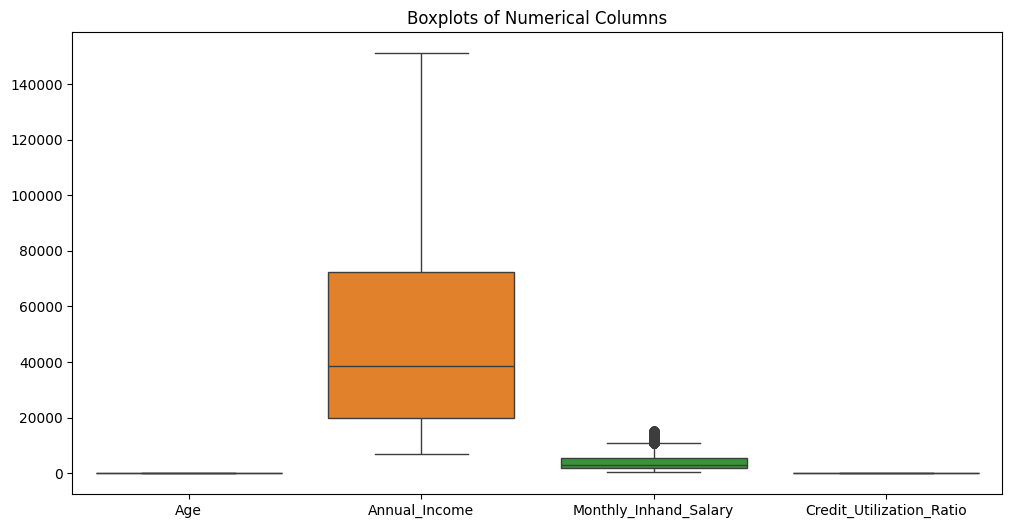

In [ ]:

# Boxplots for numerical columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_Clean[numerical_columns])
plt.title("Boxplots of Numerical Columns")
plt.show()


- Outliers in monthly salary and income could be data errors or caps.
- Further cleaning and analysis of outliers are needed.

In [ ]:
# Handle Outliers in Monthly_Inhand_Salary and Annual_Income
'''
These variables have significant outliers, which can distort analysis.

Identify outliers using the IQR (Interquartile Range) method and remove or cap them.
Log transformation can also be applied to these skewed variables to reduce the impact of large values.
'''

# Calculate IQR for 'Annual_Income' and 'Monthly_Inhand_Salary'
Q1 = df_Clean[['Annual_Income', 'Monthly_Inhand_Salary']].quantile(0.25)
Q3 = df_Clean[['Annual_Income', 'Monthly_Inhand_Salary']].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
df_Clean = df_Clean[~((df_Clean[['Annual_Income', 'Monthly_Inhand_Salary']] < (Q1 - 1.5 * IQR)) |
                  (df_Clean[['Annual_Income', 'Monthly_Inhand_Salary']] > (Q3 + 1.5 * IQR))).any(axis=1)]


In [ ]:
# Transform Skewed Data
#For Annual_Income and Monthly_Inhand_Salary, apply a log transformation to reduce skewness.
df_Clean['Annual_Income'] = np.log1p(df_Clean['Annual_Income'])
df_Clean['Monthly_Inhand_Salary'] = np.log1p(df_Clean['Monthly_Inhand_Salary'])



<Axes: xlabel='Annual_Income', ylabel='Count'>

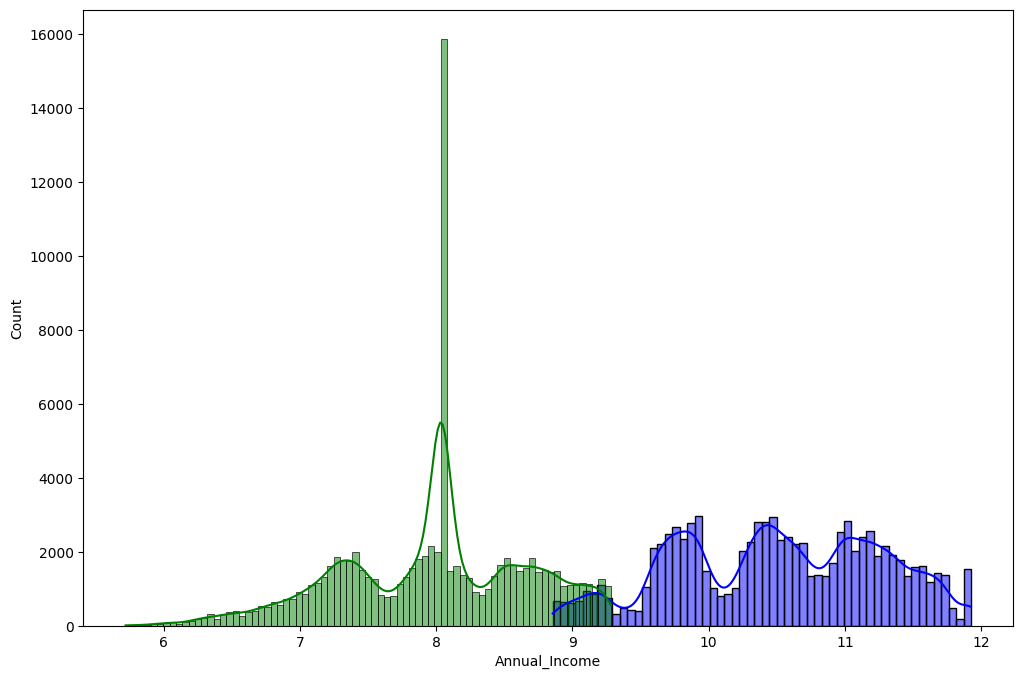

In [ ]:
# Re-plot after cleaning
plt.figure(figsize=(12, 8))
sns.histplot(df_Clean['Annual_Income'], kde=True, color='blue')
sns.histplot(df_Clean['Monthly_Inhand_Salary'], kde=True, color='green')


# Bivariate Analysis
            

              Pairplot: To visualize pairwise relationships.

              Correlation Heatmap: To identify strong correlations.

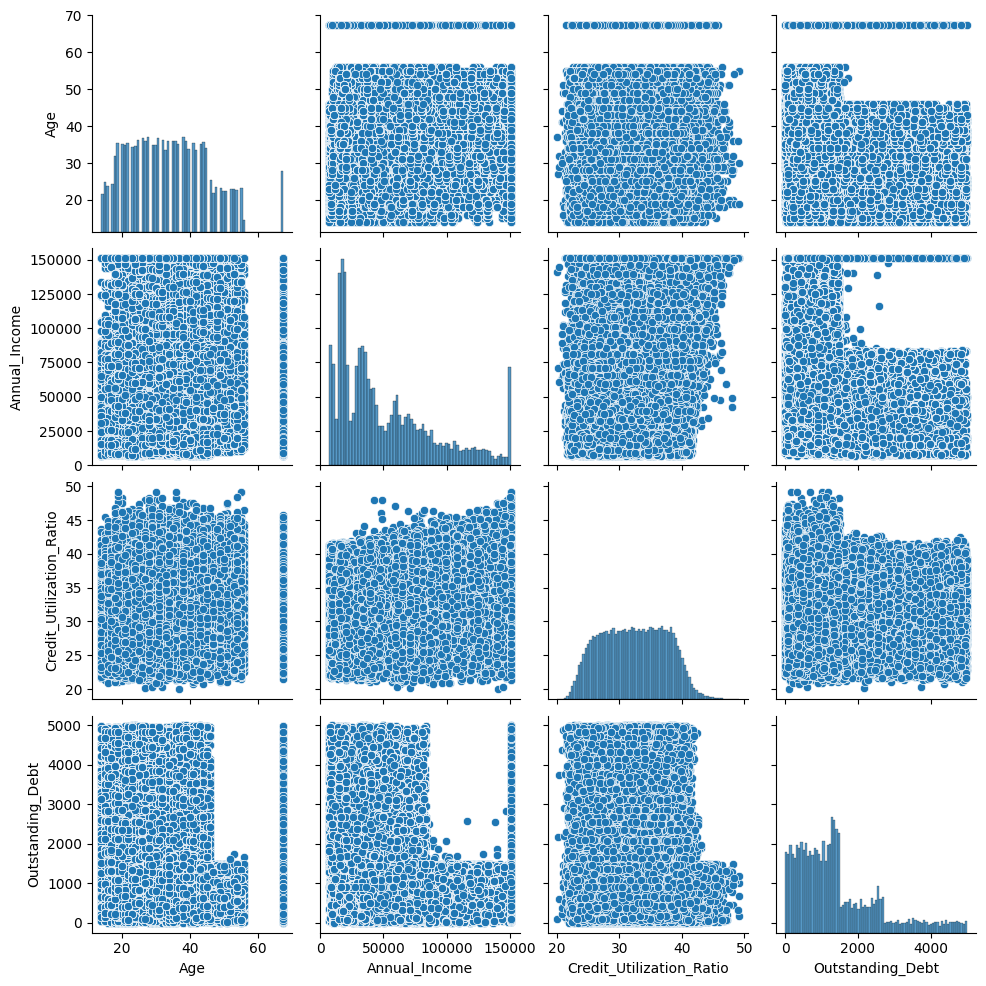

In [ ]:
# Pairplot for selected features
sns.pairplot(df_Clean[['Age', 'Annual_Income', 'Credit_Utilization_Ratio', 'Outstanding_Debt']])
plt.show()

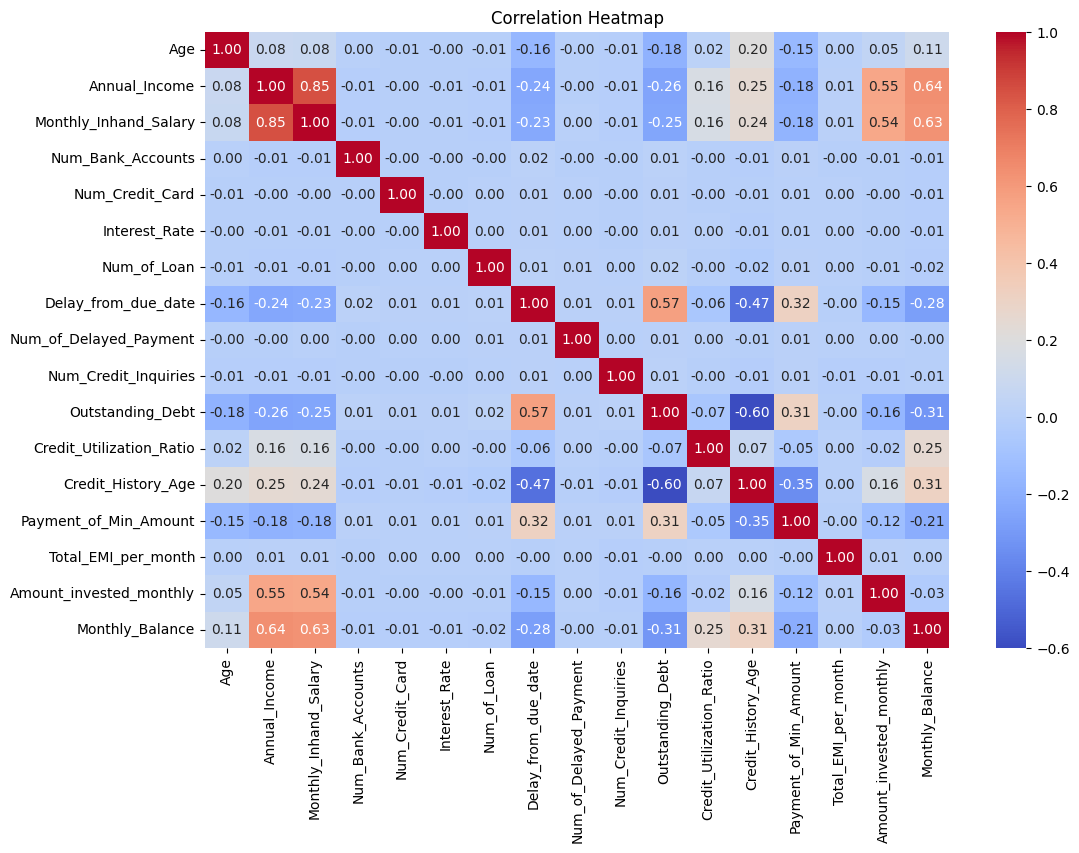

In [ ]:

# Select only numerical columns
numeric_df = df_Clean.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


- Annual_Income and Monthly_Inhand_Salary are highly related. This could be problematic for machine learning models, due to multicollinearity.

#### Numerical vs. Categorical Analysis
          Boxplots: To analyze the distribution of numerical variables across categories.


<ipython-input-61-be395ed5c458>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Credit_Mix', y='Annual_Income', data=df, palette='Set3')
<ipython-input-61-be395ed5c458>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Credit_Mix', y='Credit_Utilization_Ratio', data=df, palette='Set3')


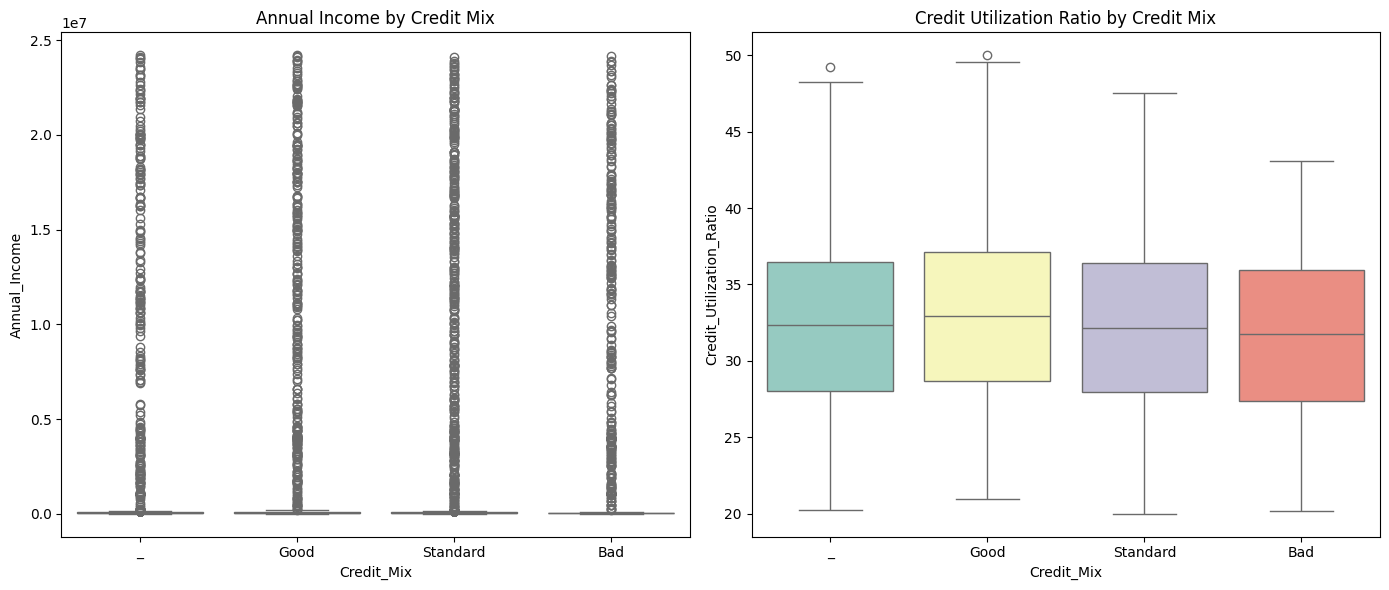

In [ ]:
# Boxplot for 'Credit_Mix' vs 'Annual_Income' and 'Credit_Utilization_Ratio'
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Credit_Mix', y='Annual_Income', data=df, palette='Set3')
plt.title('Annual Income by Credit Mix')

plt.subplot(1, 2, 2)
sns.boxplot(x='Credit_Mix', y='Credit_Utilization_Ratio', data=df, palette='Set3')
plt.title('Credit Utilization Ratio by Credit Mix')

plt.tight_layout()
plt.show()


# Multivariate Analysis


          Scatterplot with hue: Use sns.scatterplot() to analyze relationships with additional context.
          
          Cluster Analysis: Use clustering techniques to find patterns in customer segmentation.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


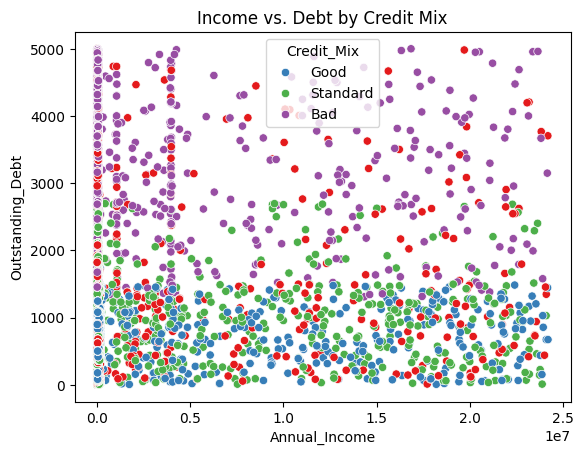

In [ ]:
# Scatterplot with Credit Mix as hue
sns.scatterplot(x='Annual_Income', y='Outstanding_Debt', hue='Credit_Mix', data=df, palette='Set1')
plt.title("Income vs. Debt by Credit Mix")
plt.show()


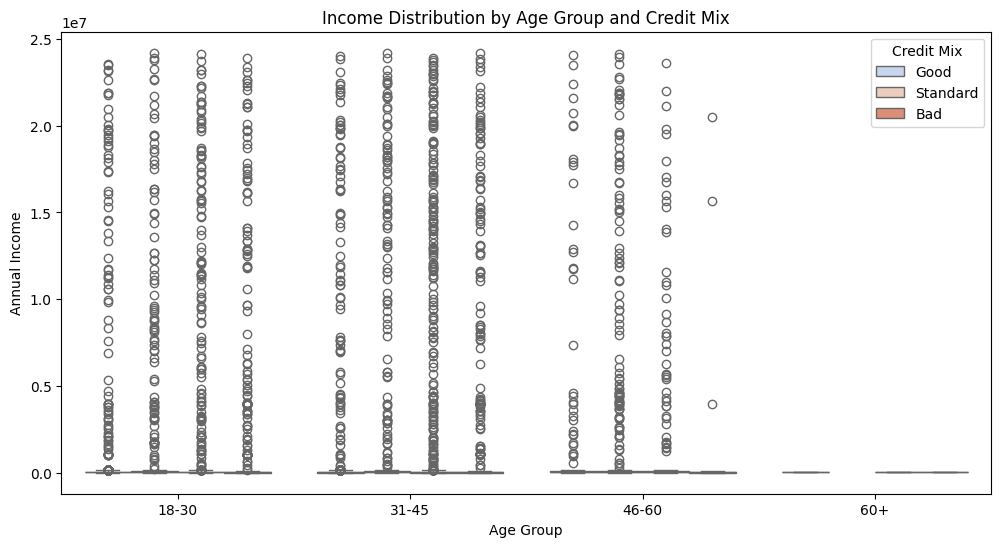

In [ ]:
# Create Age Groups
df['Age_Group'] = pd.cut(df['Age'], bins=[18, 30, 45, 60, 100], labels=['18-30', '31-45', '46-60', '60+'])

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Age_Group', y='Annual_Income', hue='Credit_Mix', data=df, palette="coolwarm")
plt.title("Income Distribution by Age Group and Credit Mix")
plt.xlabel("Age Group")
plt.ylabel("Annual Income")
plt.legend(title="Credit Mix")
plt.show()


In [ ]:
df_Clean.columns

Index(['Month', 'Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance', 'Credit_Score',
       'Credit_Mix_Good', 'Credit_Mix_Standard', 'Credit_Mix__',
       'Payment_Behaviour_High_spent_Large_value_payments',
       'Payment_Behaviour_High_spent_Medium_value_payments',
       'Payment_Behaviour_High_spent_Small_value_payments',
       'Payment_Behaviour_Low_spent_Large_value_payments',
       'Payment_Behaviour_Low_spent_Medium_value_payments',
       'Payment_Behaviour_Low_spent_Small_value_payments'],
      dtype='object')

In [ ]:
import statsmodels.api as sm

# Selecting independent variables (features)
X = df_Clean[['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Credit_Utilization_Ratio']]
X = sm.add_constant(X)  # Adds a constant term to the model

# Dependent variable (target)
y = df_Clean['Outstanding_Debt']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Display the summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       Outstanding_Debt   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     2262.
Date:                Sat, 07 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:35:29   Log-Likelihood:            -7.5958e+05
No. Observations:               90083   AIC:                         1.519e+06
Df Residuals:                   90078   BIC:                         1.519e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

- Interpretation of Coefficients:
      Constant (Intercept): 6002.1152 — When all predictors are zero, the model predicts an Outstanding Debt of 6002.12. This is the baseline value for the model.

      Age: -16.6744 — For each additional year of age, the Outstanding Debt is expected to decrease by 16.67, assuming all other factors remain constant.

      Annual Income: -280.3725 — For each additional unit of Annual Income, Outstanding Debt is expected to decrease by 280.37, assuming all other factors remain constant. This suggests that higher-income individuals tend to have lower debt, all else equal.

      Monthly Inhand Salary: -102.1111 — For each additional unit of Monthly Inhand Salary, Outstanding Debt is expected to decrease by 102.11, assuming all other factors remain constant.
      
      Credit Utilization Ratio: -6.8028 — For each additional unit of Credit Utilization Ratio, Outstanding Debt is expected to decrease by 6.80, assuming all other factors remain constant. This suggests that higher credit utilization ratios tend to correlate with lower outstanding debt, which is counterintuitive and might need further inspection.

In [ ]:
# Save preprocessed data
df_Clean.to_csv("preprocessed_data.csv", index=False)
